In [1]:
! ls

 data_exercise1.csv		  requirements.txt	  test.csv	   venv
'Data Scientist Assignment.pdf'   sample_submission.csv   train.csv
'Exercise 2.ipynb'		  submission.csv	  Untitled.ipynb


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plot

In [3]:
train = pd.read_csv("train.csv")

# Exploratory

## Basic Checks

In [4]:
train.head(3)

,product_type,user_id,join_date,hidden,product,STV,target,credit_card_level,is_lp,aff_type,is_cancelled,country_segment
0,type_ex,7.0,2018-12-01 00:01:45,0,product_1,8.25,8.25,standard,0,PPL,NaN,US
1,type_ex,20.0,2018-12-01 00:06:05,0,product_2,8.25,8.25,standard,0,PPL,NaN,US
2,type_ex,22.0,2018-12-01 00:06:23,0,product_3,8.25,8.25,prepaid,0,PPL,NaN,US


In [5]:
TARGET = "target"

In [6]:
train.describe()

,user_id,hidden,STV,target,is_lp,is_cancelled
count,8.811270e+05,881127.000000,881127.000000,881127.000000,881127.000000,807454.000000
mean,5.871019e+05,0.269827,4.897234,6.290185,0.270388,0.388225
std,3.468950e+05,0.443870,7.580178,14.620387,0.444160,0.487347
min,0.000000e+00,0.000000,-44.282250,-270.203500,0.000000,0.000000
25%,2.858625e+05,0.000000,0.397500,0.397500,0.000000,0.000000
50%,5.771410e+05,0.000000,0.397500,0.397500,0.000000,0.000000
75%,8.952105e+05,1.000000,8.250000,8.250000,1.000000,1.000000
max,1.188692e+06,1.000000,98.397150,281.811600,1.000000,1.000000


**Casting to datetime**

In [7]:
train.join_date = pd.to_datetime(train.join_date)

### Duplicated samples?

I will look for duplicated samples, creating an id for each row, using the product_type and user_id values.

In [8]:
print(train.product_type.unique())
print(f'total distinct user_id: {len(train.user_id.unique())}')

['type_ex' 'type_p' 'type_u' 'type_x']
total distinct user_id: 466844


In [9]:
train['id'] = train.product_type + "_" + train.user_id.astype(str)
ID = "id"
print(f"total rows: {len(train)}")
print(f"total distinct ids: {len(train.id.unique())}");

total rows: 881127
total distinct ids: 881127


### Nulls

Percent of nulls, just in columns with null values.

is_cancelled    9.124111
aff_type        0.000227
dtype: float64


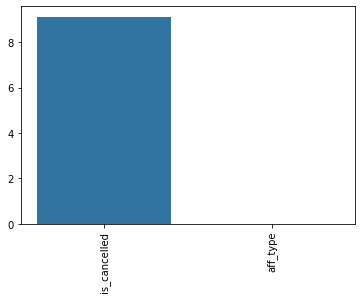

In [10]:
import matplotlib.pyplot as plt
nulls = (100.0*train.isnull().sum()/train.count()).sort_values(ascending=False)
nulls = nulls[nulls > 0]
print(nulls)
g = sns.barplot(x=nulls.index,y=nulls.values)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

### Product type
I will try to understand peculiar relations between different product types

There will be equal users quantity and users quantity with p product_type (because all users start with that):

In [11]:
assert(len(train.user_id.unique())==len(train[train.product_type=='type_p']))
print(f"Number of user_ids:{len(train.user_id.unique())}")

Number of user_ids:466844


The other product types have less or equal quantity of users that the product_type p, so I want to know how big is its market

In [12]:
total_users = len(train.user_id.unique())
total_ltv = train[TARGET].sum()
for ptype in train.product_type.unique():
    total_ptype_users = train[train.product_type==ptype].user_id.count()
    total_ptype_ltv = train[train.product_type==ptype].target.sum()
    share = 100.0*total_ptype_users/total_users
    share_ltv = 100.0*total_ptype_ltv/total_ltv
    print(f"{ptype} - share: {round(share,2)} - share_ltv:{round(share_ltv,2)} - qty:{total_ptype_users}")

type_ex - share: 15.78 - share_ltv:11.17 - qty:73673
type_p - share: 100.0 - share_ltv:43.29 - qty:466844
type_u - share: 12.11 - share_ltv:5.9 - qty:56554
type_x - share: 60.85 - share_ltv:39.65 - qty:284056


**I conclude that the importance order in product types is: type_p, type_x, type_ex and type_u**

In [13]:
PRODUCT_TYPE_IMPORTANCE_ORDER=["type_p", "type_x", "type_ex", "type_u"]

## Target (LTV)

Understanding of our Target var.

In [14]:
train[TARGET].describe()

count    881127.000000
mean          6.290185
std          14.620387
min        -270.203500
25%           0.397500
50%           0.397500
75%           8.250000
max         281.811600
Name: target, dtype: float64

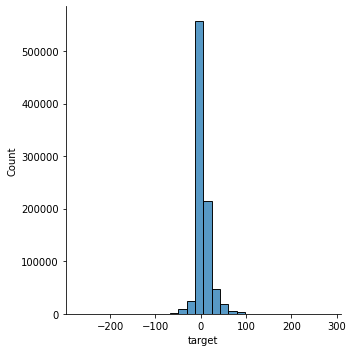

In [15]:
sns.displot(train,x=TARGET,bins=30)

### What distribution has each product_type?

In [16]:
def describe_categorical(dataframe,category):
    d = dataframe.groupby(category).agg({ID:['count'],TARGET:['sum','mean','std']})
    d.columns = d.columns.get_level_values(1).astype(str)
    d['share'] = round(100*d['count']/d['count'].sum(),2)
    #d['share'] = d['share'].map('{:.2f}'.format)
    d['mean'] = d['mean'].map('{:,.2f}'.format)
    d['std'] = d['std'].map('{:,.2f}'.format)
    d['sum'] = round(d['sum'],0)
    return d

Showing the market share in each product_type:

In [17]:
describe_categorical(train, "product_type").sort_values(by="share",ascending=False)

,count,sum,mean,std,share
product_type,,,,,
type_p,466844,2399078.0,5.14,12.19,52.98
type_x,284056,2197432.0,7.74,19.08,32.24
type_ex,73673,618915.0,8.40,1.16,8.36
type_u,56554,327026.0,5.78,15.69,6.42


Target distribution by type in US country segment:

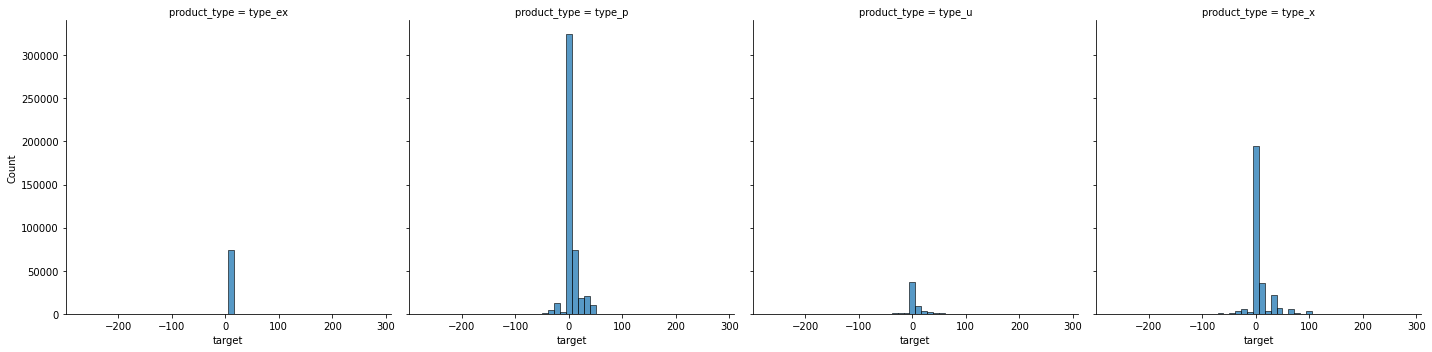

In [18]:
sns.displot(train, 
            x=TARGET, 
            col="product_type",
            bins=50,
            col_order=PRODUCT_TYPE_IMPORTANCE_ORDER)

Target distribution by type in the other ones countries(distinct to US):

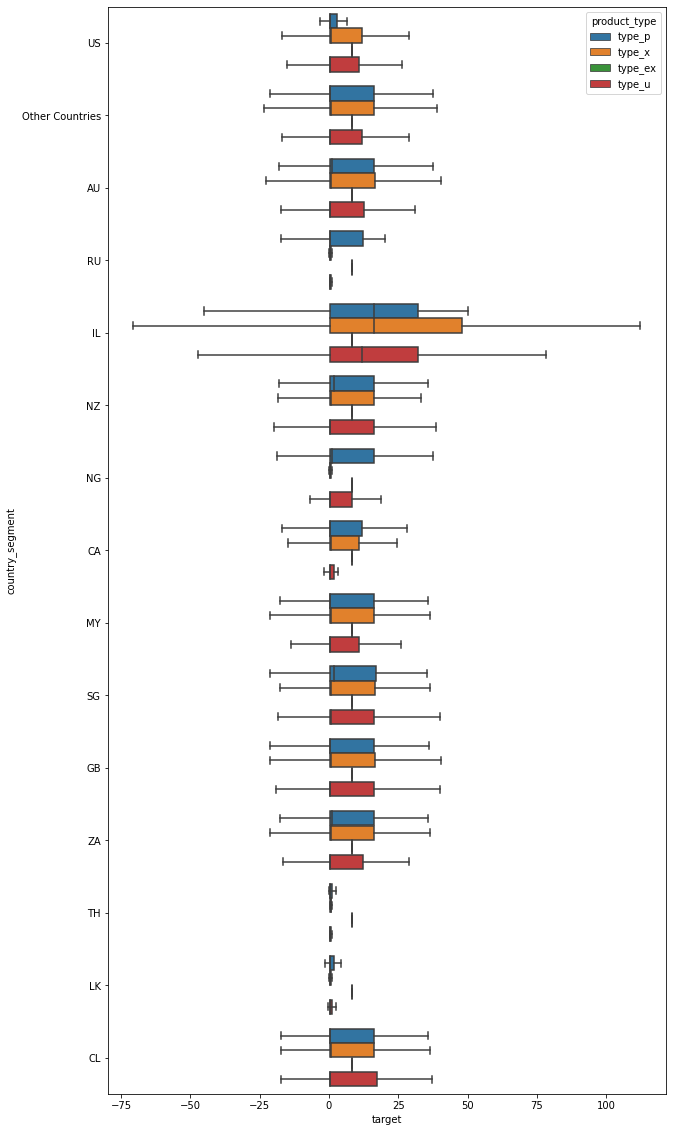

In [19]:
plt.figure(figsize=(10,20))
ax = sns.boxplot(x=TARGET, y="country_segment", hue="product_type",
                    data=train, showfliers=False, hue_order=PRODUCT_TYPE_IMPORTANCE_ORDER)

Zooming in over type_ex product type LTV values:

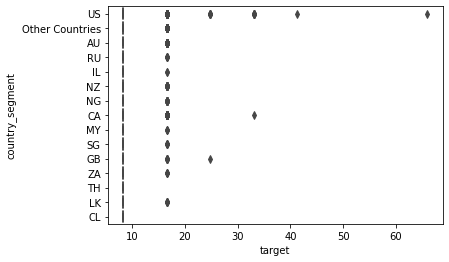

In [20]:
ax = sns.boxplot(x=TARGET,  
                 y="country_segment",
                 data=train[train.product_type=='type_ex'], 
                 showfliers=True)

### Average Selling Price (ASP)

In [21]:
pd.pivot_table(train, values='target', index=['country_segment'],
                       columns=['product_type'], aggfunc=np.mean)

product_type,type_ex,type_p,type_u,type_x
country_segment,,,,
AU,8.403298,6.075102,5.568671,9.880369
CA,8.404243,4.904526,4.644973,7.456196
CL,8.250000,8.757987,9.381839,12.075976
GB,8.406977,6.888683,8.604821,10.927505
IL,8.269053,15.315441,15.487969,24.065491
LK,8.382000,3.260861,3.064826,3.086017
MY,8.281772,6.455833,6.117580,8.175909
NG,8.322329,4.434451,3.346757,3.153550
NZ,8.380625,9.064854,7.970277,11.201269


## Categorical Columns
In the next subsections, I will try to understand the relationship between our categorical variables and our TARGET var. In order to do that, I will use boxplots, because it will show in a very simple way if the analyzed var change its target associated values, when changes its own values.

List of all categorical variables:

In [22]:
columns_to_avoid = [TARGET, ID]
categorical_cols = [c for c in list(train.select_dtypes(include='object').columns) if c not in columns_to_avoid]
print("Categirical cols:")
for c in categorical_cols:
    print(" + "+c)

Categirical cols:
 + product_type
 + product
 + credit_card_level
 + aff_type
 + country_segment


I will look the countries information in order to just analyze the most important ones in share market.

In [23]:
country_segment_description = (describe_categorical(train, "country_segment")
                                .sort_values(by='sum',ascending=False))
country_segment_description['cumulative_share'] = country_segment_description.share.cumsum()
country_segment_description

,count,sum,mean,std,share,cumulative_share
country_segment,,,,,,
US,624890,3736465.0,5.98,13.78,70.92,70.92
Other Countries,106738,740348.0,6.94,15.97,12.11,83.03
AU,33616,251021.0,7.47,19.02,3.82,86.85
CA,30267,180196.0,5.95,14.80,3.44,90.29
GB,21355,178799.0,8.37,19.13,2.42,92.71
IL,5992,104003.0,17.36,28.61,0.68,93.39
RU,15369,69677.0,4.53,10.45,1.74,95.13
NZ,7112,68074.0,9.57,15.37,0.81,95.94
NG,14653,64376.0,4.39,10.87,1.66,97.60


 I will take the top 7, that sum ~95% of share market.

In [24]:
top_countries = list(country_segment_description.head(7).index)
train_top_countries = train[train.country_segment.isin(top_countries)]

### > credit_card_level

General information about credit_card_level

In [25]:
describe_categorical(train,"credit_card_level")

,count,sum,mean,std,share
credit_card_level,,,,,
prepaid,351252,1661989.0,4.73,10.76,39.86
standard,529875,3880462.0,7.32,16.61,60.14


Share of credit_card_level by product_types. We try to understand if some prepaid_card_level value is not skewed to just one product.

<AxesSubplot:xlabel='product_type', ylabel='target'>

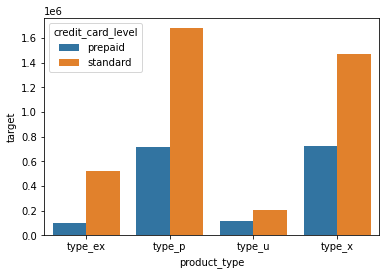

In [26]:
data = train.groupby(["product_type","credit_card_level"]).sum().target
sns.barplot(data=data.reset_index(),x='product_type',y='target',hue="credit_card_level")

We will analyze just type_p and type_x because represents the main part of our dataset.

#### credit_card_level - type_p

Relations between Country segments, credit_Card_level and our Target var; just for users with product_type equal to **type_p**

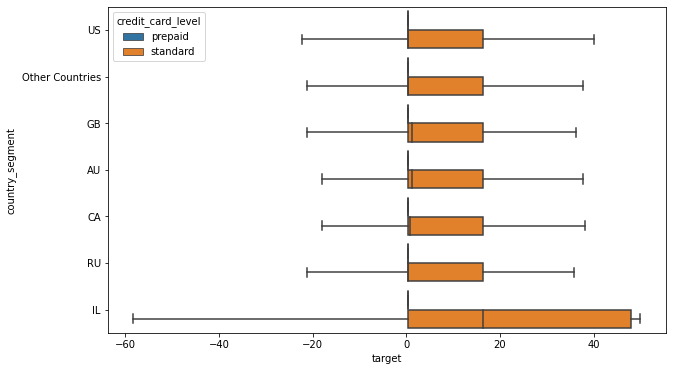

In [27]:
plt.figure(figsize=(10,6))

ax = sns.boxplot(x=TARGET, y="country_segment", hue="credit_card_level",
                    data=train_top_countries[train_top_countries.product_type=='type_p'], showfliers=False,)

#### credit_card_level - type_x

Relations between Country segments, credit_Card_level and our Target var; just for users with product_type equal to **type_x**

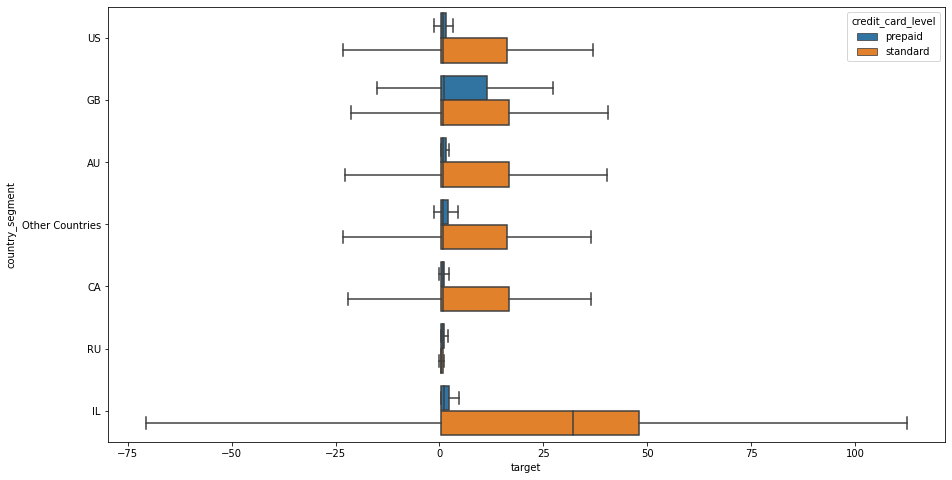

In [28]:
plt.figure(figsize=(15,8))

ax = sns.boxplot(x=TARGET, y="country_segment", hue="credit_card_level",
                    data=train_top_countries[train_top_countries.product_type=='type_x'], showfliers=False,)

#### credit_card_level - Conclussions

We found that users with prepaid credit card level has less variability in his LTV and represents a 40% percent of total samples, so, it seems a good feature.

### > product

Like we have a lot of products (exactly 10), I will select the most important ones in share market in order to visualize the relationship with our target.

In [29]:
products_description = describe_categorical(train,"product").sort_values(by='sum',ascending=False)
products_description["cumulative_share"] = products_description.share.cumsum()
products_description

,count,sum,mean,std,share,cumulative_share
product,,,,,,
product_1,432991,2800428.0,6.47,15.67,49.14,49.14
product_4,180920,1100034.0,6.08,13.30,20.53,69.67
product_2,130600,825044.0,6.32,13.73,14.82,84.49
product_3,94889,565932.0,5.96,13.57,10.77,95.26
product_5,12890,76306.0,5.92,13.85,1.46,96.72
product_7,11127,67768.0,6.09,14.02,1.26,97.98
product_6,8632,51441.0,5.96,13.20,0.98,98.96
product_8,4811,28505.0,5.93,13.37,0.55,99.51
product_10,2599,15947.0,6.14,14.16,0.29,99.80


In order to simplify our analisis we will use just the top 4, which represents 95% of samples

In [30]:
top_4_products = list(products_description.head(4).index)
train_top_products = train_top_countries[train_top_countries['product'].isin(top_4_products)]
train_top_products.head(3)

,product_type,user_id,join_date,hidden,product,STV,target,credit_card_level,is_lp,aff_type,is_cancelled,country_segment,id
0,type_ex,7.0,2018-12-01 00:01:45,0,product_1,8.25,8.25,standard,0,PPL,NaN,US,type_ex_7.0
1,type_ex,20.0,2018-12-01 00:06:05,0,product_2,8.25,8.25,standard,0,PPL,NaN,US,type_ex_20.0
2,type_ex,22.0,2018-12-01 00:06:23,0,product_3,8.25,8.25,prepaid,0,PPL,NaN,US,type_ex_22.0


How are distributed the main products in comparison with product_type

<AxesSubplot:xlabel='product_type', ylabel='target'>

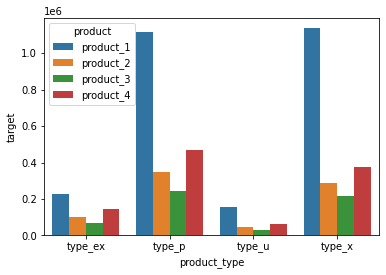

In [31]:
data = train_top_products.groupby(["product_type","product"]).sum().target
sns.barplot(data=data.reset_index(),x='product_type',y='target',hue="product")

#### Product - type_p
Relations between Country segments, products(top 4) and our Target var; just for users with product_type equal to **type_p**

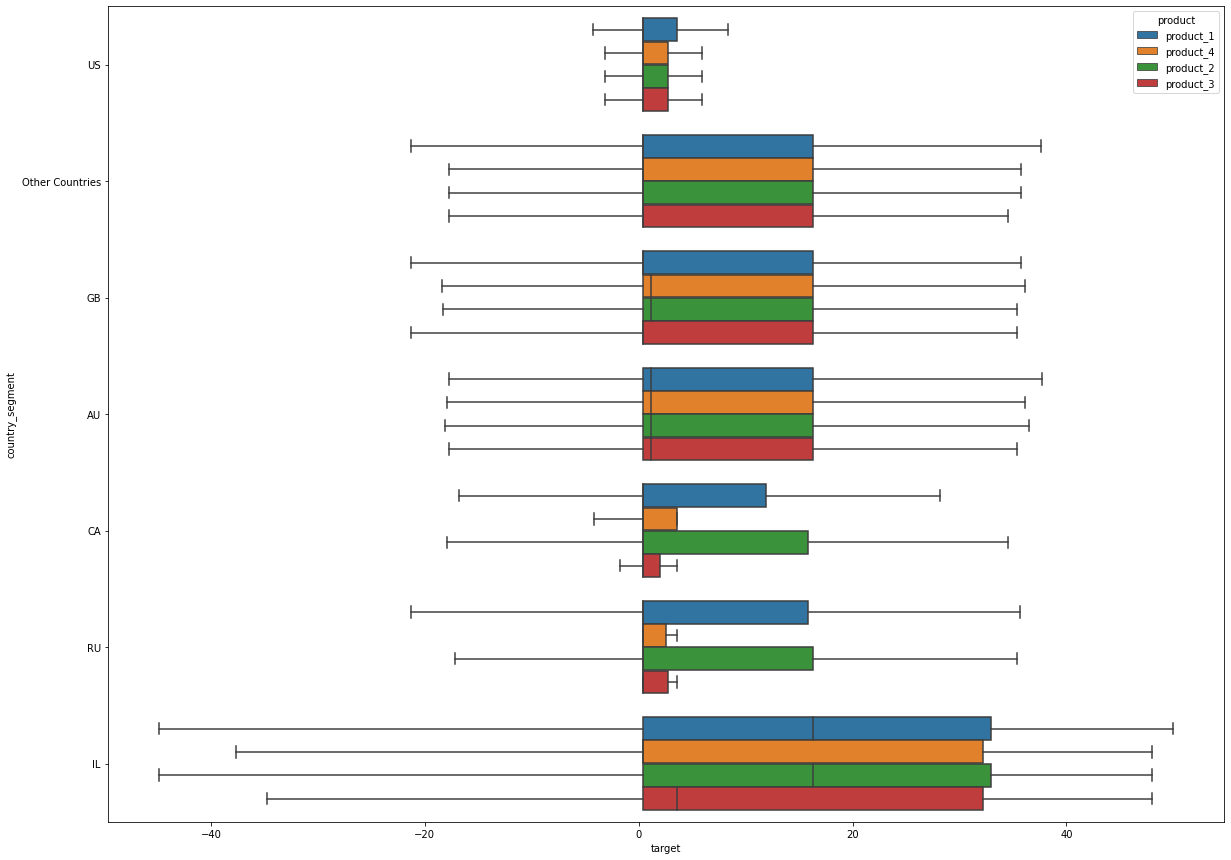

In [32]:
plt.figure(figsize=(20,15))

data = train_top_products[train_top_products.product_type=='type_p']
ax = sns.boxplot(x=TARGET, y="country_segment", hue="product",
                    data=data, showfliers=False, hue_order=top_4_products)

#### Product - type_x
Relations between Country segments, products(top 4, which represents 95% of samples) and our Target var; just for users with product_type equal to **type_x**

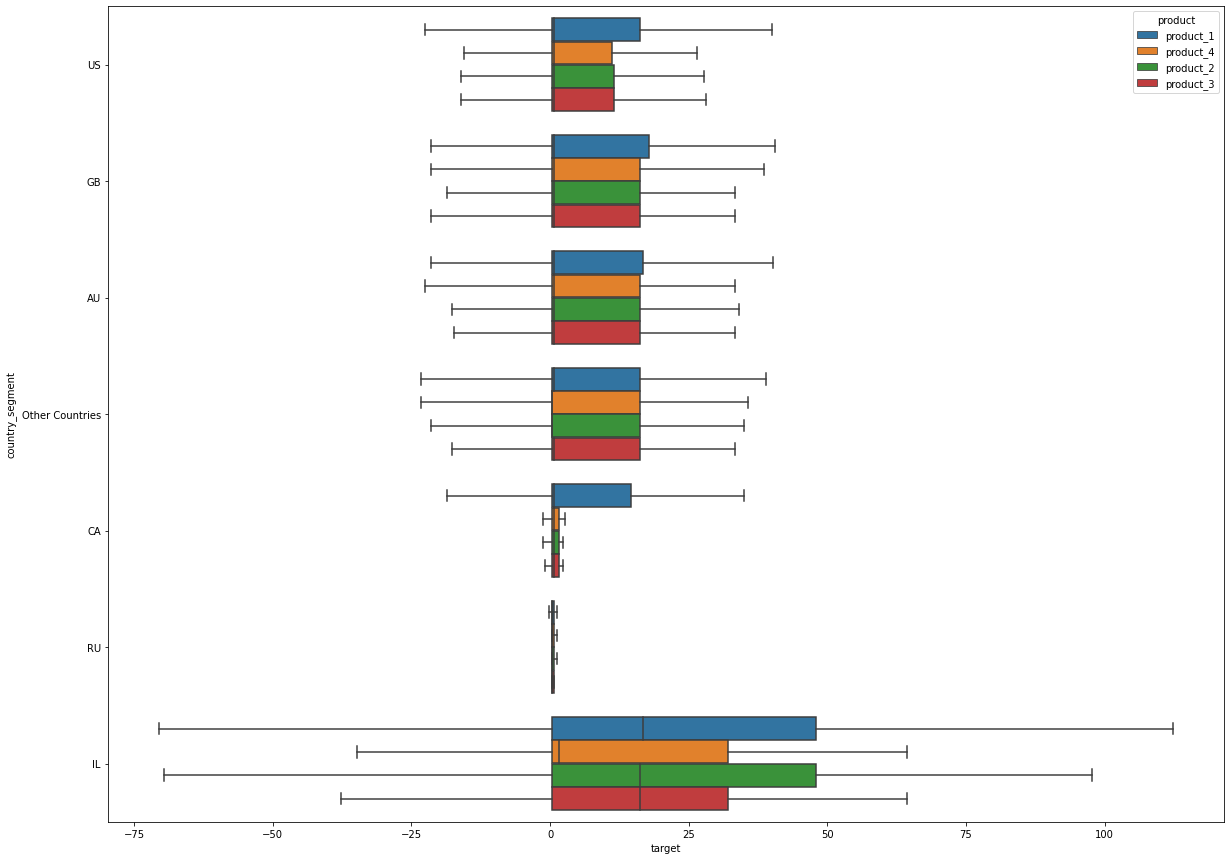

In [33]:
plt.figure(figsize=(20,15))
top_4_products = list(products_description.head(4).index)

data = train_top_countries[np.logical_and(train_top_countries.product_type=='type_x',
                                          train_top_countries['product'].isin(top_4_products))]
ax = sns.boxplot(x=TARGET, y="country_segment", hue="product",
                    data=data, showfliers=False, hue_order=top_4_products)

#### product - Conclussions
Main products in Canada(CA), or Israel(IL) is a important feature because its variance between each product give us a lot of information(In both product types). But in another ones like US, the feature has the similar target values in many products, so, has less value but is enough to keep it in our training set.

### > aff_type

How are different aff_type values distributed?

<AxesSubplot:xlabel='aff_type'>

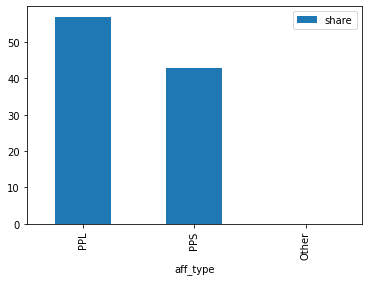

In [34]:
products_description = describe_categorical(train,"aff_type").sort_values(by='sum',ascending=False)
products_description.reset_index().plot(x="aff_type",y="share",kind="bar")

#### aff_type - type p
Relations between Country segments, aff_type and our Target var; just for users with product_type equal to **type_p**

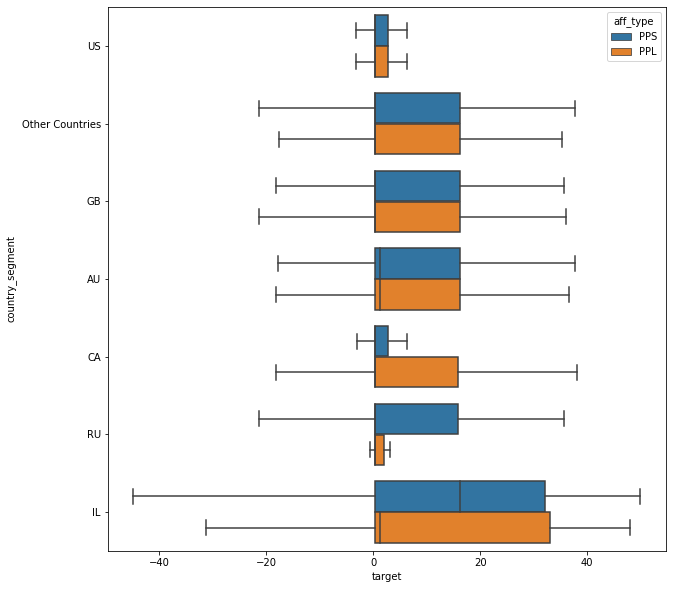

In [35]:
plt.figure(figsize=(10,10))

data = train_top_countries[train_top_countries.product_type=='type_p']
ax = sns.boxplot(x=TARGET, y="country_segment", hue="aff_type",
                    data=data, showfliers=False, hue_order=['PPS','PPL'])

#### aff_type - type x
Relations between Country segments, aff_type and our Target var; just for users with product_type equal to **type_x**

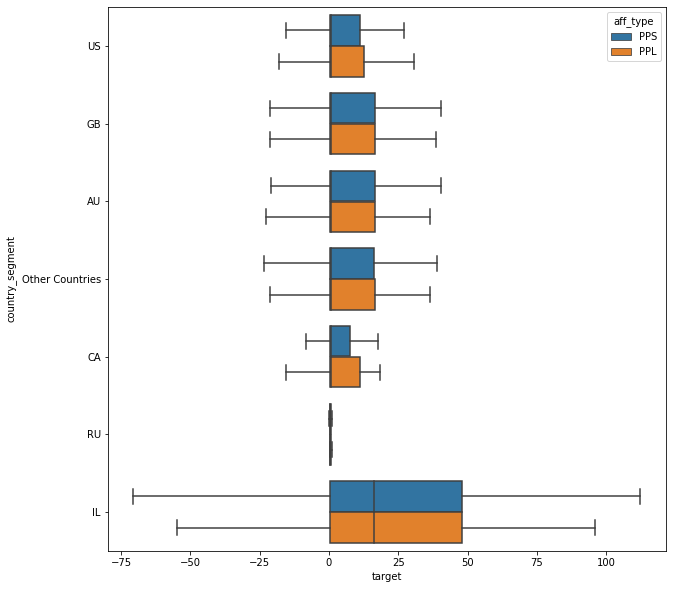

In [36]:
plt.figure(figsize=(10,10))

data = train_top_countries[train_top_countries.product_type=='type_x']
ax = sns.boxplot(x=TARGET, y="country_segment", hue="aff_type",
                    data=data, showfliers=False, hue_order=['PPS','PPL'])

#### aff_type vs is_lp
How aff_type is a traffic source characterization, I am comparing it with is_lp(another traffic source)

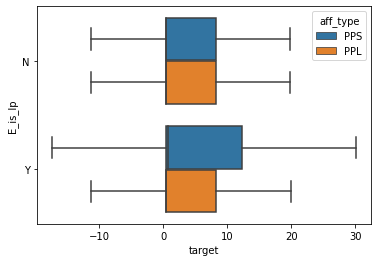

In [37]:
data = train.copy()
data["E_is_lp"] = "N"
data.loc[data.is_lp > 0, "E_is_lp"] = "Y"
ax = sns.boxplot(x=TARGET, y="E_is_lp", hue="aff_type",
                    data=data, showfliers=False, hue_order=['PPS','PPL'])

#### aff_type - Conclussions
In this analysis it seems like this variable is useless. May be we will delete it before.

## Numerical columns

In [38]:
numerical_cols = [c for c in train.select_dtypes(exclude='object').columns if c not in ['user_id','join_date']]
print("Numerical columns:")
for n in numerical_cols:
    print(" + "+n)

Numerical columns:
 + hidden
 + STV
 + target
 + is_lp
 + is_cancelled


### Distributions vs. target var

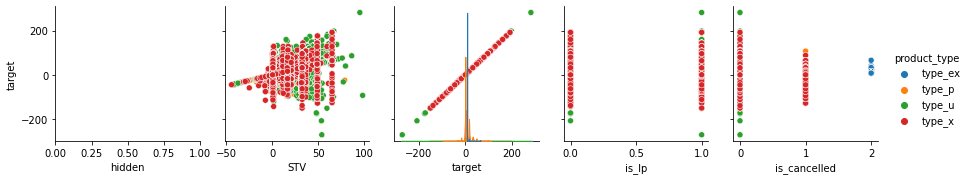

In [39]:
fixed_na_train = train.copy()
fixed_na_train.is_cancelled = fixed_na_train.is_cancelled.fillna(2)
sns.pairplot(fixed_na_train,x_vars=numerical_cols,
            y_vars=["target"], hue="product_type")

<AxesSubplot:xlabel='hidden', ylabel='target'>

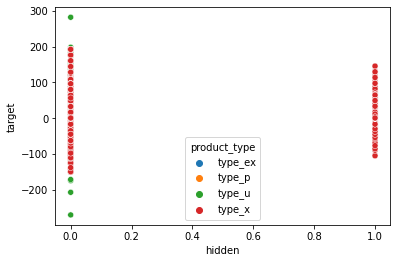

In [40]:
sns.scatterplot(data=train, x="hidden", y=TARGET, hue="product_type")

### Correlation matrix

In [41]:
corr_matrix = train[numerical_cols].corr().abs()
corr_matrix

,hidden,STV,target,is_lp,is_cancelled
hidden,1.000000,0.315540,0.185045,0.122502,0.389977
STV,0.315540,1.000000,0.501814,0.020663,0.202746
target,0.185045,0.501814,1.000000,0.012936,0.235546
is_lp,0.122502,0.020663,0.012936,1.000000,0.090108
is_cancelled,0.389977,0.202746,0.235546,0.090108,1.000000


<AxesSubplot:>

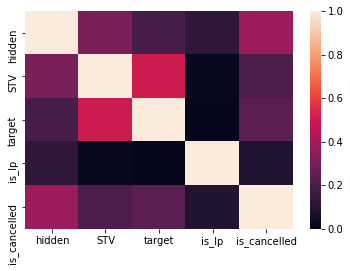

In [42]:
sns.heatmap(corr_matrix, vmin=0, vmax=1)#.astype(int)

### Conclussions

We look how STV is highly correlated with our target var, and it make sense because is a shorter picture of LTV. Additionally hidden and is_cancelled have less relation with our target, but are useful too.

## Other columns

 Just for curiosity I want to know how is the evolution of LTV by the user join date

In [43]:
from datetime import datetime, timedelta

train['join_dayofweek'] = train.join_date.dt.dayofweek
train["join_day"] = train.join_date.dt.floor('d')
train["join_week"] =  train.join_day - train.join_date.dt.weekday * timedelta(days=1)

<AxesSubplot:xlabel='join_week', ylabel='target'>

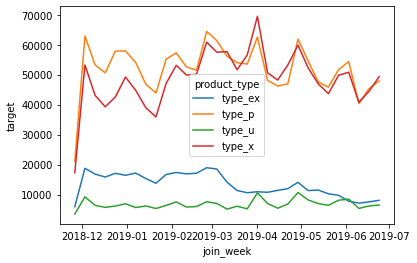

In [44]:
data = train[train.country_segment=='US'].groupby(["join_week","product_type"]).sum()
sns.lineplot(data=data.reset_index(),
             x="join_week",
             y="target", 
             hue='product_type')

The previous graphic is weird, because we find peeks in some weeks, may be a marketing campaign?

<AxesSubplot:xlabel='join_dayofweek', ylabel='target'>

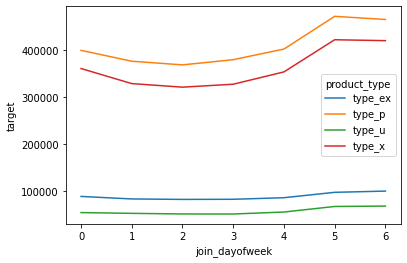

In [45]:
data = train[train.target >= 0].groupby(["join_dayofweek","product_type"]).sum()
sns.lineplot(data=data.reset_index(),
             x="join_dayofweek",
             y="target", 
             hue='product_type')

# Modeling

In order to feed correctly our models, we need to clean our data, and mixed with this we have some users that have an abnormal behaviour. Users with negative LTV are users  that use different combinations in our features looking for vulnerabilities in the system. So, I will exclude them.

In [49]:
def remove_negative_values(df):
    filter_condition = df[TARGET] >= 0
    df_filtered = df[filter_condition].reset_index(drop=True)
    percent_of_cleaned_train = 100.0*len(df_filtered)/len(df)
    print(f"Percent of cleaned dataset {round(percent_of_cleaned_train)}% ({len(df_filtered)} of {len(df)})")
    return df_filtered

filtered_train = remove_negative_values(train)

Percent of cleaned dataset 93% (822785 of 881127)


## Feature Importance

In [57]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

class Preprocessor(object):
    
    def __init__(self, train_data):
        train_data = Preprocessor._remove_null_values(train_data)
        self.train_data = train_data
        # Categorical data
        categorical_cols = self.categorical_cols()
        self.one_hot_encoder = Preprocessor._create_one_hot_encoder(train_data, categorical_cols)
        
        # Scaling STV column with robust because there are some outliers.
        robust_scalar_cols = self.robust_scalar_cols()
        X_rs = train_data[robust_scalar_cols]
        self.robust_scaler = Preprocessor._create_robust_scaler(X_rs, robust_scalar_cols)
    
    @classmethod
    def _remove_null_values(cls, df):
        df.is_cancelled = df.is_cancelled.fillna(1)
        df = df.dropna().reset_index(drop=True)
        return df
    
    def columns_to_ignore(self):
        return [ID,TARGET,'join_date','user_id','join_day','join_week','STV']
    
    def robust_scalar_cols(self):
        return ["STV"]
    
    def categorical_cols(self):
        if not len(self.train_data) >= 0:
            raise Exception("Please, first set train_data")
        columns_to_avoid = self.columns_to_ignore()
        return [c for c in list(self.train_data.select_dtypes(include='object').columns) if c not in columns_to_avoid]
    
    @classmethod
    def _create_one_hot_encoder(cls, df, categorical_cols):
        one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
        X_categorical = df[categorical_cols]
        one_hot_encoder.fit(X_categorical)
        return one_hot_encoder
    
    def _transform_categoricals(self, df):
        X_categorical = df[self.categorical_cols()]
        cat_train = self.one_hot_encoder.transform(X_categorical)
        return pd.DataFrame(cat_train.toarray(),
                            columns=self.one_hot_encoder.get_feature_names(X_categorical.columns))
    
    @classmethod
    def _create_robust_scaler(cls, df, robust_scalar_cols):
        X_rs = df[robust_scalar_cols]
        return RobustScaler().fit(X_rs)
    
    def _transform_robust_scalers(self, df):
        X_rs = df[self.robust_scalar_cols()]
        return pd.DataFrame(self.robust_scaler.transform(X_rs),columns=X_rs.columns)
    
    
    def preprocess(self, data, preserve=[]):
        data = Preprocessor._remove_null_values(data)
        data.join_date = pd.to_datetime(data.join_date)
        data['join_dayofweek'] = data.join_date.dt.dayofweek
        
        X_cat = self._transform_categoricals(data)
        Xt = self._transform_robust_scalers(data)
        
        # other columns/binary
        columns_to_ignore = self.columns_to_ignore() + self.categorical_cols()
        features = [f for f in list(data.columns) if f not in columns_to_ignore]
        features = features + preserve
        X_other = data[features]
        
        # Merging numerical columns and categorical columns
        X = pd.concat([X_other, Xt, X_cat],axis=1)
        return X

preprocessor = Preprocessor(filtered_train)
preprocessed_train = preprocessor.preprocess(filtered_train,preserve=['target'])
preprocessed_train.head(3)

,hidden,is_lp,is_cancelled,join_dayofweek,target,STV,product_type_type_ex,product_type_type_p,product_type_type_u,product_type_type_x,...,country_segment_LK,country_segment_MY,country_segment_NG,country_segment_NZ,country_segment_Other Countries,country_segment_RU,country_segment_SG,country_segment_TH,country_segment_US,country_segment_ZA
0,0,0,1.0,5,8.25,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,1.0,5,8.25,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,1.0,5,8.25,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [59]:
from sklearn.model_selection import train_test_split


y = preprocessed_train[TARGET]
X = preprocessed_train.drop([TARGET],axis=1)

# Splitting data
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y, 
                                                      test_size=0.10, 
                                                      random_state=42)

### Tree Regressor - Feature Importance

In [60]:
def create_importance_df(features, model_name, importance_values):
    importance = pd.DataFrame(X.columns, columns=['feature'])
    importance["model"] = model_name
    importance['importance_value'] = importance_values
    importance.sort_values(by='importance_value',ascending=False)
    return importance

In [61]:
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
# define dataset

# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \n'.format(model.score(X_train, y_train), 
                                                                         model.score(X_valid, y_valid)))

# get importance
importance_tree = create_importance_df(features= list(X.columns), 
                                       model_name="tree_regressor", 
                                       importance_values=model.feature_importances_ )
importance_tree.head(10)[['feature','importance_value']]

R^2 Training Score: 0.65 
R^2 Validation Score: 0.57 



,feature,importance_value
0,hidden,5.561789e-03
1,is_lp,4.538991e-03
2,is_cancelled,4.554001e-02
3,join_dayofweek,1.893759e-02
4,STV,8.819592e-01
5,product_type_type_ex,7.858198e-10
6,product_type_type_p,1.282189e-03
7,product_type_type_u,1.575772e-03
8,product_type_type_x,1.333720e-03
9,product_product_1,2.884168e-03


### Lasso Regressor - Feature Importance

In [62]:
from sklearn.linear_model import Lasso
# define the model
model = Lasso(alpha=0.01)
# fit the model
model.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}\n'.format(model.score(X_train, y_train), 
                                                                         model.score(X_valid, y_valid)))

# get importance
importance_lasso = create_importance_df(features = list(X.columns), 
                                       model_name = "lasso_regressor", 
                                       importance_values = model.coef_ )
importance_lasso.head(10)[['feature','importance_value']]

R^2 Training Score: 0.58 
R^2 Validation Score: 0.59



,feature,importance_value
0,hidden,0.451210
1,is_lp,-0.068676
2,is_cancelled,-4.386739
3,join_dayofweek,0.047983
4,STV,10.419603
5,product_type_type_ex,-1.864195
6,product_type_type_p,-0.087590
7,product_type_type_u,0.000000
8,product_type_type_x,1.263370
9,product_product_1,0.215549


## Feature Selection

I will use a feature importance technique to select the most important features automatically, but I will check if this features make sense with what I see previously in our EDA.

In the next graph, we will see lasso and tree_regressor importance values, this is for an ocular inspection if it make sense.

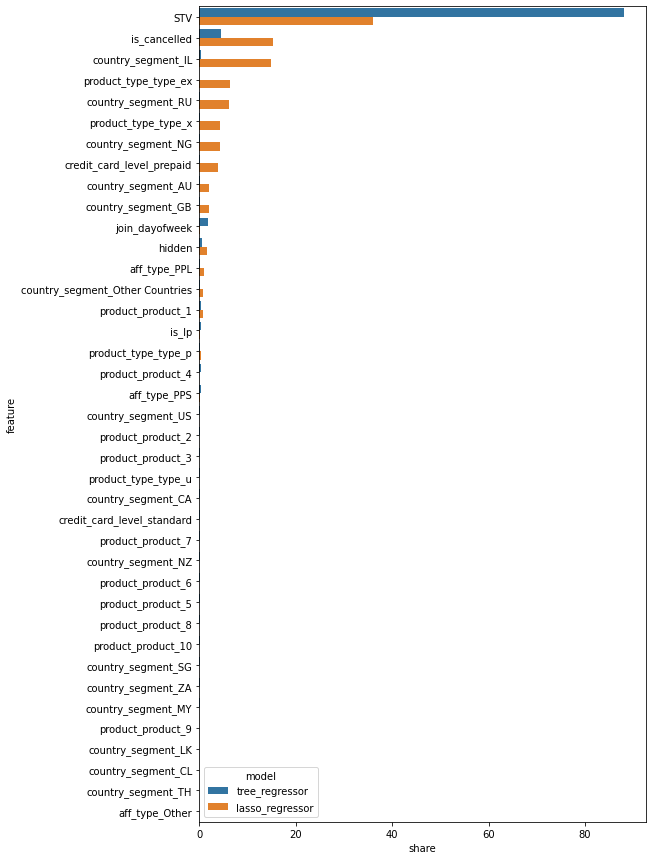

In [63]:
def column_share(df, col):
    return round(100.0*df[col].abs()/(df[col].abs().sum()),2)

importance_tree['share'] = column_share(importance_tree,"importance_value")
importance_lasso['share'] = column_share(importance_lasso,"importance_value")
importance = pd.concat([importance_tree,importance_lasso]).reset_index(drop=True)
importance = importance[["feature","share","model"]].sort_values(by=['share','feature'],ascending=False)

plt.figure(figsize=(8,15))
ax = sns.barplot(data=importance, x="share", y="feature", hue='model')
plt.show()

In [65]:
def get_best_features(importance, importance_threshold=0.5):
    cumuled_importance = importance.groupby("feature").sum().reset_index()
    share_restriction = cumuled_importance.share > importance_threshold
    best_features_list = list(cumuled_importance[share_restriction].feature.unique())
    return best_features_list

importance_threshold = 0.1
best_features_list = get_best_features(importance, importance_threshold)

X_train_best_features = X_train.copy()[best_features_list]
X_valid_best_features = X_valid.copy()[best_features_list]
best_features_list

['STV',
 'aff_type_PPL',
 'aff_type_PPS',
 'country_segment_AU',
 'country_segment_CA',
 'country_segment_GB',
 'country_segment_IL',
 'country_segment_NG',
 'country_segment_Other Countries',
 'country_segment_RU',
 'country_segment_US',
 'credit_card_level_prepaid',
 'credit_card_level_standard',
 'hidden',
 'is_cancelled',
 'is_lp',
 'join_dayofweek',
 'product_product_1',
 'product_product_2',
 'product_product_3',
 'product_product_4',
 'product_type_type_ex',
 'product_type_type_p',
 'product_type_type_u',
 'product_type_type_x']

### Conclussion 

 The best features selected by our _feature importance_ process are highly correlated with what we check in our EDA. Is innecesary have a lot of countries or features in general if his behaviour is always the same.

## Training

I will try different models and differents hyperparameters(Using grid search) looking for the best combination.
At the end, I will train a new model by each product, in order to get the best perfomance in each one.

### Looking for the best model and hyper-parameters

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestRegressor(n_jobs = 3,
                                      n_estimators=100,
                                      random_state = 42)

param_grid = {"min_samples_split":[50,100,200],"max_depth":[5,10,15]}
grid = GridSearchCV(estimator=random_forest, param_grid=param_grid, scoring='r2',cv=2, verbose=1, n_jobs=2)
grid_result = grid.fit(X_train_best_features, y_train)
model = grid_result.best_estimator_
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:  9.3min finished


Best Score:  0.6062840216144081
Best Params:  {'max_depth': 10, 'min_samples_split': 100}


In [67]:
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(model.score(X_train_best_features, y_train),
                                                                         model.score(X_valid_best_features, y_valid)))

R^2 Training Score: 0.61 
R^2 Validation Score: 0.61


In [68]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

ridge = Lasso()
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = {"alpha":alpha, "fit_intercept":[True,False] }
grid = GridSearchCV(estimator=ridge, cv=2, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train_best_features, y_train)
model = grid_result.best_estimator_
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 2 folds for each of 14 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:  1.4min finished


Best Score:  0.5827341009251432
Best Params:  {'alpha': 0.001, 'fit_intercept': True}


In [69]:
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(model.score(X_train_best_features, y_train),
                                                                         model.score(X_valid_best_features, y_valid)))

R^2 Training Score: 0.58 
R^2 Validation Score: 0.59


### Training Final model

In order to train the final model, we will create an specific model for each product_type. So we will have a r2 metric for each product_type, and additionally we will create a final one.

In [91]:
from sklearn.linear_model import Ridge
from matplotlib import pyplot
scores = {}

def filter_by_product_type(df,p):
    return df["product_type_"+p].abs() > 0

def filter_by_country_segment(df, cs):
    return df["country_segment_"+cs].abs() > 0

for p in PRODUCT_TYPE_IMPORTANCE_ORDER:
    X_train_by_ptype = X_train_best_features[filter_by_product_type(X_train, p)]
    y_train_by_ptype = y_train[filter_by_product_type(X_train, p)]
    X_valid_by_ptype = X_valid_best_features[filter_by_product_type(X_valid, p)]
    y_valid_by_ptype = y_valid[filter_by_product_type(X_valid, p)]
    # define the model
    model = RandomForestRegressor(n_jobs = 8,
                                  n_estimators=100,
                                  min_samples_split=200,
                                  max_depth = 15,
                                  random_state = 42)
    # fit the model
    model.fit(X_train_by_ptype, y_train_by_ptype)
    share = len(X_valid_by_ptype)/len(X_valid)
    
    score_train = model.score(X_train_by_ptype, y_train_by_ptype)
    score_valid = model.score(X_valid_by_ptype, y_valid_by_ptype)
    scores[p] = {"share":share, "score_valid":score_valid, "model":model}
    print('{:} R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(p,
                                                                                 score_train,
                                                                                 score_valid))
    print("Share: {:.2}% \n".format(100.0*share))

print("Final R^2 metric:")
final_score = 0
for k in scores.keys():
    final_score += scores[k]["share"]*scores[k]["score_valid"]
final_score

type_p R^2 Training Score: 0.66 
R^2 Validation Score: 0.65
Share: 5.2e+01% 

type_x R^2 Training Score: 0.58 
R^2 Validation Score: 0.59
Share: 3.2e+01% 

type_ex R^2 Training Score: 0.97 
R^2 Validation Score: 0.98
Share: 8.8% 

type_u R^2 Training Score: 0.58 
R^2 Validation Score: 0.57
Share: 6.5% 

Final R^2 metric:


0.6530815602802659

Our model was better with the feature selection process and segmenting by each product. So the next step is predict our test set.

### Working with our test set

In [81]:
test = pd.read_csv("test.csv")
print(len(test))
X_test = preprocessor.preprocess(test, preserve=["join_date"])
X_test.shape

138017


(138016, 40)

In [86]:
X_test_best_features = X_test[best_features_list]
test_df_list = []
for product_type in scores.keys():
    ptype_filter = filter_by_product_type(X_test, product_type)
    X_test_by_ptype = X_test_best_features[ptype_filter].reset_index(drop=True)
    new_df_test = X_test[ptype_filter].reset_index(drop=True)
    new_df_test['prediction'] = scores[product_type]["model"].predict(X_test_by_ptype)
    test_df_list.append(new_df_test)
test_df = pd.concat(test_df_list)
test_df.shape

(138016, 41)

In [87]:
country_segments = test.country_segment.unique()
product_types = test.product_type.unique()

test_df['product_type'] = "nan"
for p in product_types:
    p_filter = filter_by_product_type(test_df, p)
    test_df.loc[p_filter, "product_type"] = p

test_df['country_segment'] = "nan"
for cs in country_segments:
    p_filter = filter_by_country_segment(test_df, cs)
    test_df.loc[p_filter, "country_segment"] = cs

test_df.country_segment.unique()

array(['US', 'GB', 'AU', 'Other Countries', 'RU', 'CA', 'IL', 'NG', 'NZ',
       'CL', 'MY', 'SG', 'TH', 'ZA', 'LK'], dtype=object)

In [88]:
test_df["join_day"] = test_df['join_date'].dt.to_period('M').dt.to_timestamp()
table = pd.pivot_table(test_df, values='prediction', index=['join_day','country_segment'],
                       columns=['product_type'], aggfunc=np.mean)
table.to_csv("submission.csv")

In [89]:
table

product_type                 type_ex     type_p     type_u     type_x
join_day   country_segment                                           
2019-07-01 AU               8.326707   9.628801   9.859835  14.781412
           CA               8.619550   6.811362   5.709624  10.280012
           CL               8.250000   8.208589   7.437768  12.554862
           GB               8.275528   9.999345  12.104598  17.683199
           IL               8.336331  22.576277  24.581949  39.862396
           LK               8.957364   6.367983   6.426784  10.430463
           MY               8.308933   9.290980   7.124344  11.817856
           NG               8.273060   6.476716   5.740007   5.005112
           NZ               8.520492  11.591156  10.852084  16.312655
           Other Countries  8.409041   8.220410   7.783149  11.008999
           RU               8.250162   5.913123   5.103016   5.239399
           SG               8.250158  11.573696   9.166973  14.606644
           TH               8.250000   5.119843   5.231553   9.218153
           US               8.559330   6.780548   7.759714  10.704210
           ZA               8.529682  10.603514   8.141872  13.731526